# Risk evaluation machine learning service for retail banks 

Embarking on a solo data-driven entrepreneurial journey, our startup is set to revolutionize risk evaluation services for retail banks. Armed with a dataset from Home Credit Group, we're on a mission to employ machine learning for predicting loan defaults in our proof-of-concept (POC) product.

As both the data scientist and product lead, my objective is to navigate through datasets, including those from Credit Bureau, to unveil pivotal patterns. The focus is on identifying and prioritizing significant features, leading to the creation of a classification model targeting credit defaults (1 for default, 0 for non-default).

This strategic endeavor involves not only technological exploration but also the creation of a Docker image with an API endpoint, hosted on Google Cloud, showcasing our commitment to delivering impactful solutions that redefine risk assessment for retail banks.

### What are the dangers from defaulted credits:
* Financial Loss: The most immediate and direct impact on creditors is financial loss. A default means that the lender may not receive the full amount of money lent, leading to a decrease in the lender's revenue and potential financial instability.

* Increased Costs: Creditors may incur additional costs associated with the collection process. This can include expenses related to hiring collection agencies, pursuing legal action, or engaging in other efforts to recover the outstanding debt.

* Impact on Profitability: Defaults can directly impact the profitability of a lender. The loss of expected repayments can affect the overall financial performance and bottom line of the lending institution.

* Risk Management Challenges: Creditors need to actively manage credit risk to prevent widespread defaults. High default rates may indicate weaknesses in the credit risk assessment and underwriting processes, requiring adjustments to lending practices.

* Reputation Risk: Experiencing a high number of defaults can harm a creditor's reputation. Lenders are often viewed negatively if they are associated with lending to individuals or businesses that frequently default, which can impact their ability to attract new customers.

### Evaluation metric
We will be evaluating models on AUC_ROC curve, but main focus will be on a recall of minor class(defaulted credits), to capture as many defaulted credits with model as possible

## Notebook 1  "Data tables reading and statistically significant features selection" 

### Objectives of this notebook
* Read data tables
* Explore data
* Engineer features 
* Find statistically significant features to target variable "TARGET" (0 : not defaulted credits ,1 : Credit default)

In [2]:
import pandas as pd
import numpy as np
import shap
from collections import Counter
import warnings
import scipy
import joblib
from sklearn import metrics
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold,KFold
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import sweetviz as sv
from IPython.display import display, IFrame,Image
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns
import analysis_functions
from IPython.display import display, IFrame
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


%matplotlib inline

# Data structure and how it's related

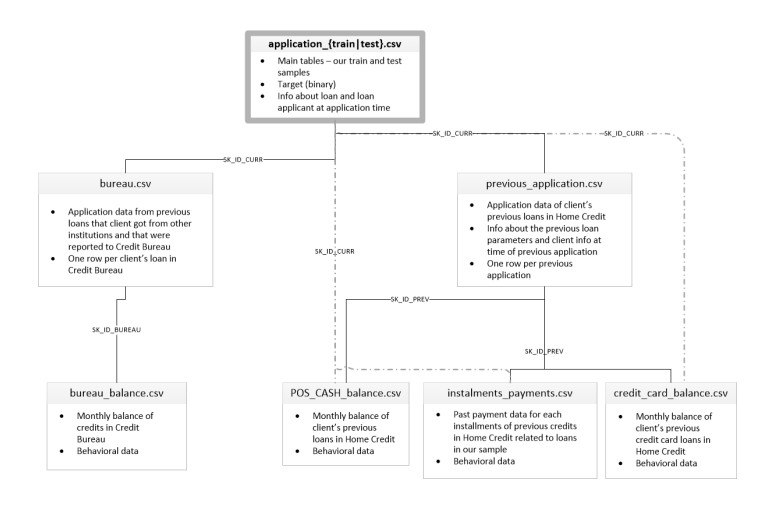

In [2]:
display(Image(filename='Loan_data_structure.png'))

In [3]:
df_train = pd.read_csv("home-credit-default-risk/application_train.csv")

## Aplication dataset 

,Table,Row,Description,Special
* SK_ID_CURR,ID of loan in our sample,
* TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",
* NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,
* CODE_GENDER,Gender of the client,
* FLAG_OWN_CAR,Flag if the client owns a car,
* FLAG_OWN_REALTY,Flag if client owns a house or flat,
* CNT_CHILDREN,Number of children the client has,
* AMT_INCOME_TOTAL,Income of the client,
* AMT_CREDIT,Credit amount of the loan,
* AMT_ANNUITY,Loan annuity,
* AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,
* NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,
* NAME_INCOME_TYPE,"Clients income type (businessman, working, maternity leave,�)",
* NAME_EDUCATION_TYPE,Level of highest education the client achieved,
* NAME_FAMILY_STATUS,Family status of the client,
* NAME_HOUSING_TYPE,"What is the housing situation of the client (renting, living with parents, ...)",
* REGION_POPULATION_RELATIVE,Normalized population of region where client lives (higher number means the client lives in more populated region),normalized 
* DAYS_BIRTH,Client's age in days at the time of application,time only relative to the application
* DAYS_EMPLOYED,How many days before the application the person started current employment,time only relative to the application
* DAYS_REGISTRATION,How many days before the application did client change his registration,time only relative to the application
* DAYS_ID_PUBLISH,How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
* OWN_CAR_AGE,Age of client's car,
* FLAG_MOBIL,"Did client provide mobile phone (1=YES, 0=NO)",
* FLAG_EMP_PHONE,"Did client provide work phone (1=YES, 0=NO)",
* FLAG_WORK_PHONE,"Did client provide home phone (1=YES, 0=NO)",
* FLAG_CONT_MOBILE,"Was mobile phone reachable (1=YES, 0=NO)",
* FLAG_PHONE,"Did client provide home phone (1=YES, 0=NO)",
* FLAG_EMAIL,"Did client provide email (1=YES, 0=NO)",
* OCCUPATION_TYPE,What kind of occupation does the client have,
* CNT_FAM_MEMBERS,How many family members does client have,
* REGION_RATING_CLIENT,"Our rating of the region where client lives (1,2,3)",
* REGION_RATING_CLIENT_W_CITY,"Our rating of the region where client lives with taking city into account (1,2,3)",
* WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for the loan,
* HOUR_APPR_PROCESS_START,Approximately at what hour did the client apply for the loan,rounded
* REG_REGION_NOT_LIVE_REGION,"Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)",
* REG_REGION_NOT_WORK_REGION,"Flag if client's permanent address does not match work address (1=different, 0=same, at region level)",
* LIVE_REGION_NOT_WORK_REGION,"Flag if client's contact address does not match work address (1=different, 0=same, at region level)",
* REG_CITY_NOT_LIVE_CITY,"Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)",
* REG_CITY_NOT_WORK_CITY,"Flag if client's permanent address does not match work address (1=different, 0=same, at city level)",
* LIVE_CITY_NOT_WORK_CITY,"Flag if client's contact address does not match work address (1=different, 0=same, at city level)",
* ORGANIZATION_TYPE,Type of organization where client works,
* EXT_SOURCE_1,Normalized score from external data source,normalized
* EXT_SOURCE_2,Normalized score from external data source,normalized
* EXT_SOURCE_3,Normalized score from external data source,normalized
* APARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* BASEMENTAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* YEARS_BEGINEXPLUATATION_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* YEARS_BUILD_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* COMMONAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* ELEVATORS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* ENTRANCES_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* FLOORSMAX_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* FLOORSMIN_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LANDAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LIVINGAPARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LIVINGAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* NONLIVINGAPARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* NONLIVINGAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* APARTMENTS_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* BASEMENTAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* YEARS_BEGINEXPLUATATION_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* YEARS_BUILD_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* COMMONAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* ELEVATORS_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* ENTRANCES_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* FLOORSMAX_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* FLOORSMIN_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LANDAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LIVINGAPARTMENTS_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LIVINGAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* NONLIVINGAPARTMENTS_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* NONLIVINGAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* APARTMENTS_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* BASEMENTAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* YEARS_BEGINEXPLUATATION_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* YEARS_BUILD_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* COMMONAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* ELEVATORS_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* ENTRANCES_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* FLOORSMAX_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* FLOORSMIN_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LANDAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LIVINGAPARTMENTS_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* LIVINGAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* NONLIVINGAPARTMENTS_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* NONLIVINGAREA_MEDI,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* FONDKAPREMONT_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* HOUSETYPE_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* TOTALAREA_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* WALLSMATERIAL_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* EMERGENCYSTATE_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
* OBS_30_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings with observable 30 DPD (days past due) default,
* DEF_30_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings defaulted on 30 DPD (days past due) ,
* OBS_60_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings with observable 60 DPD (days past due) default,
* DEF_60_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings defaulted on 60 (days past due) DPD,
* DAYS_LAST_PHONE_CHANGE,How many days before application did client change phone,
* FLAG_DOCUMENT_2,Did client provide document 2,
* FLAG_DOCUMENT_3,Did client provide document 3,
* FLAG_DOCUMENT_4,Did client provide document 4,

In [4]:
df_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_target = df_train[["SK_ID_CURR", "TARGET"]].copy()

In [6]:
df_target.to_csv('Loan_target.csv')

Creating dataframe target with client ID and Target variable, for features selections and their significance checking from other tables 

In [7]:
df_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [ ]:
analyze_report = sv.analyze(df_train, "TARGET")

                                             |          | [  0%]   00:00 -> (? left)

In [10]:
analyze_report.show_html("Loan_target.html")

Report Loan_target.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [8]:
html_file_path = "Loan_target.html"

IFrame(html_file_path, width="100%", height=1000)

From sweetvizz report about train dataset we can see that there is a lot o features which has missing values more than 48%. Those features will be droped

## Train dataframe comparison , after spliting it by target column 

In [4]:
df_target_0 = df_train[df_train['TARGET'] == 0]
df_target_1 = df_train[df_train['TARGET'] == 1]

In [5]:
train_comparison = sv.compare(df_target_0, df_target_1)

                                             |          | [  0%]   00:00 -> (? left)

### Rejected loans data is collor blue, accepted is orange.

In [6]:
train_comparison.show_html("Train_target_comparison.html")

Report Train_target_comparison.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [3]:
html_file_path = "Train_target_comparison.html"

IFrame(html_file_path, width="100%", height=1000)

In [19]:
threshold = 0.53 * len(df_train)

df_train_cleaned = df_train.dropna(axis=1, thresh=threshold)

df_train_cleaned

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


After cleaning features with more than 47% of missing values , we have lost 30 features, almost one fourth of all features

In [11]:
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

## Statistical test, every feature , tested against target variable

* Mann-Whitney U test for every numerical features () non-parametric test, which doesn't require feature to be in normal distribution)
* Chi-square test for every categorical and bool features
* Significance level = 0.05
* Purpose:  To select significant features, that has value for future modeling

In [29]:
numerical_features = df_train_cleaned.select_dtypes(include=['float64']).columns
categorical_features = df_train_cleaned.select_dtypes(include=['object']).columns
bool_categorical_features = df_train_cleaned.select_dtypes(include=['int64']).columns


In [30]:
bool_categorical_features

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

In [31]:
sign_app_cat_feat =analysis_functions.chi_squared_test(features=categorical_features , target="TARGET", df=df_train_cleaned)
sign_app_num_feat = analysis_functions.mann_whitney_test(features=numerical_features, target="TARGET", df=df_train_cleaned)
sign_app_bool_feat = analysis_functions.chi_squared_test(features=bool_categorical_features, target="TARGET", df=df_train_cleaned)
sign_app_feat = list(sign_app_cat_feat.keys()) + list(sign_app_num_feat.keys()) +list(sign_app_bool_feat.keys())

Feature 'NAME_CONTRACT_TYPE' is significant with p-value = 0.0000
Feature 'CODE_GENDER' is significant with p-value = 0.0000
Feature 'FLAG_OWN_CAR' is significant with p-value = 0.0000
Feature 'FLAG_OWN_REALTY' is significant with p-value = 0.0007
Feature 'NAME_TYPE_SUITE' is significant with p-value = 0.0000
Feature 'NAME_INCOME_TYPE' is significant with p-value = 0.0000
Feature 'NAME_EDUCATION_TYPE' is significant with p-value = 0.0000
Feature 'NAME_FAMILY_STATUS' is significant with p-value = 0.0000
Feature 'NAME_HOUSING_TYPE' is significant with p-value = 0.0000
Feature 'OCCUPATION_TYPE' is significant with p-value = 0.0000
Feature 'WEEKDAY_APPR_PROCESS_START' is significant with p-value = 0.0174
Feature 'ORGANIZATION_TYPE' is significant with p-value = 0.0000
Feature 'AMT_INCOME_TOTAL' is significant with p-value = 0.0000
Feature 'AMT_CREDIT' is significant with p-value = 0.0000
Feature 'AMT_ANNUITY' is not significant with p-value = nan
Feature 'AMT_GOODS_PRICE' is not significan

In [32]:
print(f"Amount of significant features that were found in the main application table is: {len(sign_app_feat)}")

Amount of significant features that were found in the main application table is: 42


### All significant features by significance test in main application data table 

In [34]:
sign_app_feat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'TARGET',
 'CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_18']

In [12]:
df_train_cleaned = df_train_cleaned.set_index('SK_ID_CURR')

In [14]:
df_significant_train =  df_train_cleaned[sign_app_feat.keys()]

In [15]:
df_significant_train = df_significant_train.reset_index()

In [16]:
df_significant_train


,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,100002,202500.0,406597.5,0.018801,-3648.0,1,0,-9461,-2120,1,...,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,100003,270000.0,1293502.5,0.003541,-1186.0,0,0,-16765,-291,1,...,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,100004,67500.0,135000.0,0.010032,-4260.0,0,0,-19046,-2531,1,...,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,100006,135000.0,312682.5,0.008019,-9833.0,0,0,-19005,-2437,1,...,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,100007,121500.0,513000.0,0.028663,-4311.0,0,0,-19932,-3458,1,...,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,157500.0,254700.0,0.032561,-8456.0,0,0,-9327,-1982,1,...,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services
307507,456252,72000.0,269550.0,0.025164,-4388.0,0,0,-20775,-4090,0,...,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA
307508,456253,153000.0,677664.0,0.005002,-6737.0,0,0,-14966,-5150,1,...,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School
307509,456254,171000.0,370107.0,0.005313,-2562.0,1,0,-11961,-931,1,...,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1


From aplication dataset , we have 41 statistically significant features, 1 target feature and 1 ID feature

In [17]:
df_significant_train.to_csv('significant_train_final.csv', index=False)

Saving dataframe with target variable and significant variables to a csv file.

# Bureu data reading, EDA, preparation to join main table

* All client's previous credits provided by other financial institutions that were
reported to Credit Bureau (for clients who have a loan in our sample).
* For every loan in our sample, there are as many rows as number of credits the
client had in Credit Bureau before the application date.

Description of bureau.csv features

* SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau ",hashed
* SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),hashed
* CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,
* CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
* DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,time only relative to the application
* CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample,
* DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application
* DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit),time only relative to the application
* AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),
* CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged,
* AMT_CREDIT_SUM,Current credit amount for the Credit Bureau credit,
* AMT_CREDIT_SUM_DEBT,Current debt on Credit Bureau credit,
* AMT_CREDIT_SUM_LIMIT,Current credit limit of credit card reported in Credit Bureau,
* AMT_CREDIT_SUM_OVERDUE,Current amount overdue on Credit Bureau credit,
* CREDIT_TYPE,"Type of Credit Bureau credit (Car, cash,...)",
* DAYS_CREDIT_UPDATE,How many days before loan application did last information about the Credit Bureau credit come,time only relative to the application
* AMT_ANNUITY,Annuity of the Credit Bureau credit,

In [18]:
df_bureau = pd.read_csv("home-credit-default-risk/bureau.csv")
df_bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


bureau records data example

In [19]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


bureau table features data types

In [21]:
bureu_analyze_report = sv.analyze(df_bureau)

                                             |          | [  0%]   00:00 -> (? left)

In [22]:
bureu_analyze_report.show_html("Bureu_report.html")

Report Bureu_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [4]:
html_file_path = "Bureu_report.html"

IFrame(html_file_path, width="100%", height=1000)

In [24]:
df_bureau_processed = analysis_functions.keep_top_categories(df_bureau, 'CREDIT_CURRENCY', 1)

Leaving in a dataset Credit type top 2 most frequent values, other are made to "Other"

In [25]:
df_bureau_processed = analysis_functions.keep_top_categories(df_bureau, 'CREDIT_TYPE', 2)

In [26]:
df_bureau_processed.CREDIT_TYPE.value_counts()

Consumer credit    1251615
Credit card         402195
Other                62618
Name: CREDIT_TYPE, dtype: int64

In [27]:
df_bureau_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [28]:
threshold = 0.7 * len(df_bureau_processed)

df_bureau_processed = df_bureau_processed.dropna(axis=1, thresh=threshold)

df_bureau_processed

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,0,91323.00,0.0,0.0,Consumer credit,-131
1,215354,5714463,Active,currency 1,-208,0,1075.0,0,225000.00,171342.0,0.0,Credit card,-20
2,215354,5714464,Active,currency 1,-203,0,528.0,0,464323.50,NaN,0.0,Consumer credit,-16
3,215354,5714465,Active,currency 1,-203,0,NaN,0,90000.00,NaN,0.0,Credit card,-16
4,215354,5714466,Active,currency 1,-629,0,1197.0,0,2700000.00,NaN,0.0,Consumer credit,-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,0,11250.00,11250.0,0.0,Other,-19
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,0,38130.84,0.0,0.0,Consumer credit,-2493
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,0,15570.00,NaN,0.0,Consumer credit,-967
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,0,36000.00,0.0,0.0,Consumer credit,-1508


Keeping features only which has less than 30% of missing values. Missing values are obsticale, because from this dataset later we will make clusters and for clustering there has to be no missing values.

In [29]:
df_bureau_processed.isna().sum()

SK_ID_CURR                     0
SK_ID_BUREAU                   0
CREDIT_ACTIVE                  0
CREDIT_CURRENCY                0
DAYS_CREDIT                    0
CREDIT_DAY_OVERDUE             0
DAYS_CREDIT_ENDDATE       105553
CNT_CREDIT_PROLONG             0
AMT_CREDIT_SUM                13
AMT_CREDIT_SUM_DEBT       257669
AMT_CREDIT_SUM_OVERDUE         0
CREDIT_TYPE                    0
DAYS_CREDIT_UPDATE             0
dtype: int64

In [30]:
bureau_categorical_features = df_bureau_processed.select_dtypes(include=['object']).columns.tolist()


encoder_bureau = OneHotEncoder(sparse=False)

In [31]:
encoder_bureau.fit(df_bureau_processed[bureau_categorical_features])

encoded_features = encoder_bureau.transform(df_bureau_processed[bureau_categorical_features])

df_bureau_encoded = pd.DataFrame(encoded_features, columns=encoder_bureau.get_feature_names_out(bureau_categorical_features))


In [32]:
joblib.dump(encoder_bureau, 'ohe_encoder_bureau')


['ohe_encoder_bureau']

In [33]:
encoded_features= encoder_bureau.get_feature_names_out()

In [34]:
encoded_features

array(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_Other', 'CREDIT_CURRENCY_currency 1',
       'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card',
       'CREDIT_TYPE_Other'], dtype=object)

In [35]:
df_bureau_processed

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,0,91323.00,0.0,0.0,Consumer credit,-131
1,215354,5714463,Active,currency 1,-208,0,1075.0,0,225000.00,171342.0,0.0,Credit card,-20
2,215354,5714464,Active,currency 1,-203,0,528.0,0,464323.50,NaN,0.0,Consumer credit,-16
3,215354,5714465,Active,currency 1,-203,0,NaN,0,90000.00,NaN,0.0,Credit card,-16
4,215354,5714466,Active,currency 1,-629,0,1197.0,0,2700000.00,NaN,0.0,Consumer credit,-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,0,11250.00,11250.0,0.0,Other,-19
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,0,38130.84,0.0,0.0,Consumer credit,-2493
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,0,15570.00,NaN,0.0,Consumer credit,-967
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,0,36000.00,0.0,0.0,Consumer credit,-1508


In [36]:
df_bureau_processed = df_bureau_processed.drop(columns=bureau_categorical_features)

df_bureau_encoded = pd.concat([df_bureau_processed, df_bureau_encoded], axis=1)

In [37]:
df_bureau_encoded 

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_Other,CREDIT_CURRENCY_currency 1,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Other
0,215354,5714462,-497,0,-153.0,0,91323.00,0.0,0.0,-131,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,215354,5714463,-208,0,1075.0,0,225000.00,171342.0,0.0,-20,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,215354,5714464,-203,0,528.0,0,464323.50,NaN,0.0,-16,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,215354,5714465,-203,0,NaN,0,90000.00,NaN,0.0,-16,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,215354,5714466,-629,0,1197.0,0,2700000.00,NaN,0.0,-21,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0,0,11250.00,11250.0,0.0,-19,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1716424,100044,5057754,-2648,0,-2433.0,0,38130.84,0.0,0.0,-2493,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1716425,100044,5057762,-1809,0,-1628.0,0,15570.00,NaN,0.0,-967,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1716426,246829,5057770,-1878,0,-1513.0,0,36000.00,0.0,0.0,-1508,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [38]:
df_bureau_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 19 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   SK_ID_CURR                   int64  
 1   SK_ID_BUREAU                 int64  
 2   DAYS_CREDIT                  int64  
 3   CREDIT_DAY_OVERDUE           int64  
 4   DAYS_CREDIT_ENDDATE          float64
 5   CNT_CREDIT_PROLONG           int64  
 6   AMT_CREDIT_SUM               float64
 7   AMT_CREDIT_SUM_DEBT          float64
 8   AMT_CREDIT_SUM_OVERDUE       float64
 9   DAYS_CREDIT_UPDATE           int64  
 10  CREDIT_ACTIVE_Active         float64
 11  CREDIT_ACTIVE_Bad debt       float64
 12  CREDIT_ACTIVE_Closed         float64
 13  CREDIT_ACTIVE_Sold           float64
 14  CREDIT_CURRENCY_Other        float64
 15  CREDIT_CURRENCY_currency 1   float64
 16  CREDIT_TYPE_Consumer credit  float64
 17  CREDIT_TYPE_Credit card      float64
 18  CREDIT_TYPE_Other            float64
dtype

Encoding categorical features, for further processing

In [39]:
numerical_features = df_bureau_encoded.drop(columns=encoded_features,axis=1)
categorical_features = df_bureau_encoded[encoded_features]
columns_to_exclude = ['SK_ID_CURR', 'SK_ID_BUREAU']
numerical_features = numerical_features.drop(columns=columns_to_exclude,axis=1)

df_grouped_bureau = df_bureau_encoded.groupby('SK_ID_CURR').agg({
    **{num_feature: np.nanmean for num_feature in numerical_features},
    **{cat_feature: 'sum' for cat_feature in categorical_features}
}).reset_index()

df_grouped_bureau.rename(columns={col: f'{col}_count' for col in categorical_features}, inplace=True)

Grouping table by current customer id and getting mean of numerical features, in calculations excluding nan values and for categorical features, getting sum of category instances

In [40]:
df_grouped_bureau

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Sold_count,CREDIT_CURRENCY_Other_count,CREDIT_CURRENCY_currency 1_count,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Other_count
0,100001,-735.000000,0.0,82.428571,0.000000,2.076236e+05,85240.928571,0.0,-93.142857,3.0,0.0,4.0,0.0,0.0,7.0,7.0,0.0,0.0
1,100002,-874.000000,0.0,-349.000000,0.000000,1.081319e+05,49156.200000,0.0,-499.875000,2.0,0.0,6.0,0.0,0.0,8.0,4.0,4.0,0.0
2,100003,-1400.750000,0.0,-544.500000,0.000000,2.543501e+05,0.000000,0.0,-816.000000,1.0,0.0,3.0,0.0,0.0,4.0,2.0,2.0,0.0
3,100004,-867.000000,0.0,-488.500000,0.000000,9.451890e+04,0.000000,0.0,-532.000000,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0
4,100005,-190.666667,0.0,439.333333,0.000000,2.190420e+05,189469.500000,0.0,-54.333333,2.0,0.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,-1667.076923,0.0,-1232.333333,0.000000,2.841430e+05,16307.100000,0.0,-1064.538462,2.0,0.0,11.0,0.0,0.0,13.0,9.0,3.0,1.0
305807,456250,-862.000000,0.0,1288.333333,0.000000,1.028820e+06,744013.365000,0.0,-60.333333,2.0,0.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0
305808,456253,-867.500000,0.0,280.500000,0.000000,9.900000e+05,448958.250000,0.0,-253.250000,2.0,0.0,2.0,0.0,0.0,4.0,3.0,1.0,0.0
305809,456254,-1104.000000,0.0,-859.000000,0.000000,4.500000e+04,0.000000,0.0,-401.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [45]:
merged_bureau_df = pd.merge(df_grouped_bureau, df_target, on='SK_ID_CURR', how='inner')

In [46]:
merged_bureau_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263491 entries, 0 to 263490
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   SK_ID_CURR                         263491 non-null  int64  
 1   DAYS_CREDIT                        263491 non-null  float64
 2   CREDIT_DAY_OVERDUE                 263491 non-null  float64
 3   DAYS_CREDIT_ENDDATE                261242 non-null  float64
 4   CNT_CREDIT_PROLONG                 263491 non-null  float64
 5   AMT_CREDIT_SUM                     263490 non-null  float64
 6   AMT_CREDIT_SUM_DEBT                256131 non-null  float64
 7   AMT_CREDIT_SUM_OVERDUE             263491 non-null  float64
 8   DAYS_CREDIT_UPDATE                 263491 non-null  float64
 9   CREDIT_ACTIVE_Active_count         263491 non-null  float64
 10  CREDIT_ACTIVE_Bad debt_count       263491 non-null  float64
 11  CREDIT_ACTIVE_Closed_count         2634

In [47]:
merged_bureau_df

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Sold_count,CREDIT_CURRENCY_Other_count,CREDIT_CURRENCY_currency 1_count,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Other_count,TARGET
0,100002,-874.000000,0.0,-349.000000,0.000000,108131.945625,49156.20000,0.0,-499.875000,2.0,0.0,6.0,0.0,0.0,8.0,4.0,4.0,0.0,1
1,100003,-1400.750000,0.0,-544.500000,0.000000,254350.125000,0.00000,0.0,-816.000000,1.0,0.0,3.0,0.0,0.0,4.0,2.0,2.0,0.0,0
2,100004,-867.000000,0.0,-488.500000,0.000000,94518.900000,0.00000,0.0,-532.000000,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0
3,100007,-1149.000000,0.0,-783.000000,0.000000,146250.000000,0.00000,0.0,-783.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
4,100008,-757.333333,0.0,-391.333333,0.000000,156148.500000,80019.00000,0.0,-611.000000,1.0,0.0,2.0,0.0,0.0,3.0,3.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263486,456247,-1043.181818,0.0,1449.818182,0.090909,471405.681818,365565.00000,0.0,-768.818182,3.0,0.0,8.0,0.0,0.0,11.0,9.0,1.0,1.0,0
263487,456249,-1667.076923,0.0,-1232.333333,0.000000,284142.973846,16307.10000,0.0,-1064.538462,2.0,0.0,11.0,0.0,0.0,13.0,9.0,3.0,1.0,0
263488,456253,-867.500000,0.0,280.500000,0.000000,990000.000000,448958.25000,0.0,-253.250000,2.0,0.0,2.0,0.0,0.0,4.0,3.0,1.0,0.0,0
263489,456254,-1104.000000,0.0,-859.000000,0.000000,45000.000000,0.00000,0.0,-401.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1


In [48]:
encoded_features = [item + '_count' for item in encoded_features]
print(encoded_features)

['CREDIT_ACTIVE_Active_count', 'CREDIT_ACTIVE_Bad debt_count', 'CREDIT_ACTIVE_Closed_count', 'CREDIT_ACTIVE_Sold_count', 'CREDIT_CURRENCY_Other_count', 'CREDIT_CURRENCY_currency 1_count', 'CREDIT_TYPE_Consumer credit_count', 'CREDIT_TYPE_Credit card_count', 'CREDIT_TYPE_Other_count']


In [49]:
numerical_features = merged_bureau_df.drop(columns=encoded_features,axis=1)
categorical_features = merged_bureau_df[encoded_features]
columns_to_exclude = ['SK_ID_CURR',"TARGET"]
numerical_features = numerical_features.drop(columns=columns_to_exclude,axis=1)

## Bureau data features significance test's 

* Mann-Whitney U test for every numerical features () non-parametric test, which doesn't require feature to be in normal distribution)
* Chi-square test for every categorical and bool features
* Significance level = 0.05
* Purpose:  To select significant features, that has value for future modeling

In [50]:
sign_bureau_cat_feat =analysis_functions.chi_squared_test(features=categorical_features, target="TARGET", df=merged_bureau_df)
sign_bureau_num_feat = analysis_functions.mann_whitney_test(features=numerical_features, target="TARGET", df=merged_bureau_df)
sign_bureau_feat = list(sign_bureau_cat_feat.keys()) + list(sign_bureau_num_feat.keys())

Feature 'CREDIT_ACTIVE_Active_count' is significant with p-value = 0.0000
Feature 'CREDIT_ACTIVE_Bad debt_count' is not significant with p-value = 0.1018
Feature 'CREDIT_ACTIVE_Closed_count' is significant with p-value = 0.0000
Feature 'CREDIT_ACTIVE_Sold_count' is significant with p-value = 0.0000
Feature 'CREDIT_CURRENCY_Other_count' is not significant with p-value = 0.1901
Feature 'CREDIT_CURRENCY_currency 1_count' is significant with p-value = 0.0000
Feature 'CREDIT_TYPE_Consumer credit_count' is significant with p-value = 0.0000
Feature 'CREDIT_TYPE_Credit card_count' is significant with p-value = 0.0000
Feature 'CREDIT_TYPE_Other_count' is significant with p-value = 0.0000
Feature 'DAYS_CREDIT' is significant with p-value = 0.0000
Feature 'CREDIT_DAY_OVERDUE' is significant with p-value = 0.0000
Feature 'DAYS_CREDIT_ENDDATE' is not significant with p-value = nan
Feature 'CNT_CREDIT_PROLONG' is significant with p-value = 0.0006
Feature 'AMT_CREDIT_SUM' is not significant with p-va

## significant bureau data features to target variable:

In [52]:
sign_bureau_feat

['CREDIT_ACTIVE_Active_count',
 'CREDIT_ACTIVE_Closed_count',
 'CREDIT_ACTIVE_Sold_count',
 'CREDIT_CURRENCY_currency 1_count',
 'CREDIT_TYPE_Consumer credit_count',
 'CREDIT_TYPE_Credit card_count',
 'CREDIT_TYPE_Other_count',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE']

In [53]:
df_grouped_bureau = df_grouped_bureau.set_index('SK_ID_CURR')

In [54]:
df_grouped_bureau = df_grouped_bureau[sign_bureau_feat]

df_grouped_bureau.columns = [f'{col}_Bureau' for col in df_grouped_bureau.columns]

In [55]:
df_grouped_bureau = df_grouped_bureau.reset_index()

In [ ]:
df_grouped_bureau.to_csv('preprocessed_bureau_data_final.csv', index=False)

# Bureau balance data

* SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table ,hashed
* MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application
* STATUS,"Status of Credit Bureau loan during the month (active, closed, DPD0-30,… 
[C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )",


In [41]:
df_bureau_balance = pd.read_csv("home-credit-default-risk/bureau_balance.csv")

In [42]:
df_bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [45]:
bureau_balance_analyze_report = sv.analyze(df_bureau_balance)

                                             |          | [  0%]   00:00 -> (? left)

In [46]:
bureau_balance_analyze_report.show_html("Bureau_balance.html")

Report Bureau_balance.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [5]:
html_file_path = "Bureau_balance.html"

IFrame(html_file_path, width="100%", height=1000)

Because  df bureu balance has more than half less unique SK_ID_BUREAU	 than in bureau dataset,  bureu balance dataset wont be merged with bureau dataset 

# POS_CASH_balance

### POS CASH balance overview

* Monthly balance snapshots of previous POS (point of sales) and cash loans that
the applicant had with Home Credit.
* This table has one row for each month of history of every previous credit in
Home Credit (consumer credit and cash loans) related to loans in our sample –
i.e. the table has (#loans in sample * # of relative previous credits * # of
months in which we have some history observable for the previous credits) rows.

###  POS CASH balance features describsion

* SK_ID_PREV ,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",
* SK_ID_CURR,ID of loan in our sample,
* MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application
* CNT_INSTALMENT,Term of previous credit (can change over time),
* CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,
* NAME_CONTRACT_STATUS,Contract status during the month,
* SK_DPD,DPD (days past due) during the month of previous credit,
* SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,

In [59]:
POS_CASH_balance = pd.read_csv(r"home-credit-default-risk/POS_CASH_balance.csv", encoding='latin1')

POS_CASH_balance

In [60]:
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [61]:
POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


All features are numerical , just NAME_CONTRACT_STATUS feature is categorical type

In [62]:
POS_CASH_report = sv.analyze(POS_CASH_balance)

                                             |          | [  0%]   00:00 -> (? left)

In [63]:
POS_CASH_report.show_html("POS_CASH_report.html")

Report POS_CASH_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [6]:
html_file_path = "POS_CASH_report.html"

IFrame(html_file_path, width="100%", height=1000)

* Dataset looks clean. There are only two features which has missing values, but it makes only 1% of these features.
* NAME_CONTRACT_STATUS feature has 9 unique values. Only top three features  has  more than 10000 records, we will keep those 3 features and others will be replaced with value "Other"

In [65]:
POS_CASH_balance_processed = analysis_functions.keep_top_categories(POS_CASH_balance, 'NAME_CONTRACT_STATUS', 3)

##  Aggregation of Pos cash table features 

In [66]:
POS_CASH_categorical_features = POS_CASH_balance_processed.select_dtypes(include=['object']).columns.tolist()


encoder_POS_CASH = OneHotEncoder(sparse=False)

In [67]:
encoder_POS_CASH.fit(POS_CASH_balance_processed[POS_CASH_categorical_features])

encoded_features = encoder_POS_CASH.transform(POS_CASH_balance_processed[POS_CASH_categorical_features])

POS_CASH_balance_encoded = pd.DataFrame(encoded_features, columns=encoder_POS_CASH.get_feature_names_out(POS_CASH_categorical_features))

In [68]:
joblib.dump(encoder_POS_CASH, 'ohe_encoder_POS_CASH')

['ohe_encoder_POS_CASH']

In [69]:
encoded_POS_CASH_features= encoder_POS_CASH.get_feature_names_out()

In [70]:
POS_CASH_balance_processed = POS_CASH_balance_processed.drop(columns=POS_CASH_categorical_features)

POS_CASH_balance_encoded = pd.concat([POS_CASH_balance_processed, POS_CASH_balance_encoded], axis=1)

In [71]:
POS_CASH_balance_encoded

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Other,NAME_CONTRACT_STATUS_Signed
0,1803195,182943,-31,48.0,45.0,0,0,1.0,0.0,0.0,0.0
1,1715348,367990,-33,36.0,35.0,0,0,1.0,0.0,0.0,0.0
2,1784872,397406,-32,12.0,9.0,0,0,1.0,0.0,0.0,0.0
3,1903291,269225,-35,48.0,42.0,0,0,1.0,0.0,0.0,0.0
4,2341044,334279,-35,36.0,35.0,0,0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,843,0,1.0,0.0,0.0,0.0
10001354,1717234,141565,-19,12.0,0.0,602,0,1.0,0.0,0.0,0.0
10001355,1283126,315695,-21,10.0,0.0,609,0,1.0,0.0,0.0,0.0
10001356,1082516,450255,-22,12.0,0.0,614,0,1.0,0.0,0.0,0.0


In [72]:
numerical_features = POS_CASH_balance_encoded.drop(columns=encoded_POS_CASH_features,axis=1)
categorical_features = POS_CASH_balance_encoded[encoded_POS_CASH_features]
columns_to_exclude = ['SK_ID_CURR',"SK_ID_PREV"]
numerical_features = numerical_features.drop(columns=columns_to_exclude,axis=1)

df_grouped_POS_Cash = POS_CASH_balance_encoded.groupby('SK_ID_CURR').agg({
    **{num_feature: np.nanmean for num_feature in numerical_features},
    **{cat_feature: 'sum' for cat_feature in categorical_features}
}).reset_index()

df_grouped_POS_Cash.rename(columns={col: f'{col}_count' for col in categorical_features}, inplace=True)

In [73]:
df_grouped_POS_Cash

,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active_count,NAME_CONTRACT_STATUS_Completed_count,NAME_CONTRACT_STATUS_Other_count,NAME_CONTRACT_STATUS_Signed_count
0,100001,-72.555556,4.000000,1.444444,0.777778,0.777778,7.0,2.0,0.0,0.0
1,100002,-10.000000,24.000000,15.000000,0.000000,0.000000,19.0,0.0,0.0,0.0
2,100003,-43.785714,10.107143,5.785714,0.000000,0.000000,26.0,2.0,0.0,0.0
3,100004,-25.500000,3.750000,2.250000,0.000000,0.000000,3.0,1.0,0.0,0.0
4,100005,-20.000000,11.700000,7.200000,0.000000,0.000000,9.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
337247,456251,-5.000000,7.875000,4.375000,0.000000,0.000000,7.0,1.0,0.0,1.0
337248,456252,-79.000000,6.000000,3.000000,0.000000,0.000000,6.0,1.0,0.0,0.0
337249,456253,-79.235294,6.705882,2.000000,0.294118,0.294118,15.0,2.0,0.0,0.0
337250,456254,-5.550000,14.900000,10.350000,0.000000,0.000000,20.0,0.0,0.0,0.0


In [74]:
merged_PosCash_df = pd.merge(df_grouped_POS_Cash, df_target, on='SK_ID_CURR', how='inner')

In [75]:
merged_PosCash_df

,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active_count,NAME_CONTRACT_STATUS_Completed_count,NAME_CONTRACT_STATUS_Other_count,NAME_CONTRACT_STATUS_Signed_count,TARGET
0,100002,-10.000000,24.000000,15.000000,0.000000,0.000000,19.0,0.0,0.0,0.0,1
1,100003,-43.785714,10.107143,5.785714,0.000000,0.000000,26.0,2.0,0.0,0.0,0
2,100004,-25.500000,3.750000,2.250000,0.000000,0.000000,3.0,1.0,0.0,0.0,0
3,100006,-9.619048,12.000000,8.650000,0.000000,0.000000,18.0,2.0,1.0,0.0,0
4,100007,-33.636364,15.333333,8.969697,0.000000,0.000000,62.0,3.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
289439,456251,-5.000000,7.875000,4.375000,0.000000,0.000000,7.0,1.0,0.0,1.0,0
289440,456252,-79.000000,6.000000,3.000000,0.000000,0.000000,6.0,1.0,0.0,0.0,0
289441,456253,-79.235294,6.705882,2.000000,0.294118,0.294118,15.0,2.0,0.0,0.0,0
289442,456254,-5.550000,14.900000,10.350000,0.000000,0.000000,20.0,0.0,0.0,0.0,1


In [76]:
encoded_POS_CASH_features = [item + '_count' for item in encoded_POS_CASH_features]
print(encoded_POS_CASH_features)

['NAME_CONTRACT_STATUS_Active_count', 'NAME_CONTRACT_STATUS_Completed_count', 'NAME_CONTRACT_STATUS_Other_count', 'NAME_CONTRACT_STATUS_Signed_count']


# Significance tests for data table Pos_Cash balance in Home credit

* Mann-Whitney U test for every numerical features () non-parametric test, which doesn't require feature to be in normal distribution)
* Chi-square test for every categorical and bool features
* Significance level = 0.05
* Purpose:  To select significant features, that has value for future modeling

In [77]:
numerical_features = merged_PosCash_df.drop(columns=encoded_POS_CASH_features,axis=1)
categorical_features = merged_PosCash_df[encoded_POS_CASH_features]
columns_to_exclude = ['SK_ID_CURR',"TARGET"]
numerical_features = numerical_features.drop(columns=columns_to_exclude,axis=1)

In [78]:
sign_PosCash_cat_feat =analysis_functions.chi_squared_test(features=categorical_features, target="TARGET", df=merged_PosCash_df)
sign_PosCash_num_feat = analysis_functions.mann_whitney_test(features=numerical_features, target="TARGET", df=merged_PosCash_df)
sign_PosCash_feat = list(sign_bureau_cat_feat.keys()) + list(sign_bureau_num_feat.keys())

Feature 'NAME_CONTRACT_STATUS_Active_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_STATUS_Completed_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_STATUS_Other_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_STATUS_Signed_count' is not significant with p-value = 0.4663
Feature 'MONTHS_BALANCE' is significant with p-value = 0.0000
Feature 'CNT_INSTALMENT' is not significant with p-value = nan
Feature 'CNT_INSTALMENT_FUTURE' is not significant with p-value = nan
Feature 'SK_DPD' is significant with p-value = 0.0000
Feature 'SK_DPD_DEF' is significant with p-value = 0.0000


### Significant features in Pos cash table to target variable 

In [79]:
sign_PosCash_feat

['NAME_CONTRACT_STATUS_Active_count',
 'NAME_CONTRACT_STATUS_Completed_count',
 'NAME_CONTRACT_STATUS_Other_count',
 'MONTHS_BALANCE',
 'SK_DPD',
 'SK_DPD_DEF']

In [80]:
df_grouped_POS_Cash = df_grouped_POS_Cash.set_index("SK_ID_CURR")

In [81]:
df_final_pos_cash = df_grouped_POS_Cash[sign_bureau_feat]

In [82]:
df_final_pos_cash.columns = [f'{col}_pos_cash' for col in df_final_pos_cash.columns]

In [83]:
df_final_pos_cash = df_final_pos_cash.reset_index()

In [84]:
df_final_pos_cash

,SK_ID_CURR,NAME_CONTRACT_STATUS_Active_count_pos_cash,NAME_CONTRACT_STATUS_Completed_count_pos_cash,NAME_CONTRACT_STATUS_Other_count_pos_cash,MONTHS_BALANCE_pos_cash,SK_DPD_pos_cash,SK_DPD_DEF_pos_cash
0,100001,7.0,2.0,0.0,-72.555556,0.777778,0.777778
1,100002,19.0,0.0,0.0,-10.000000,0.000000,0.000000
2,100003,26.0,2.0,0.0,-43.785714,0.000000,0.000000
3,100004,3.0,1.0,0.0,-25.500000,0.000000,0.000000
4,100005,9.0,1.0,0.0,-20.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
337247,456251,7.0,1.0,0.0,-5.000000,0.000000,0.000000
337248,456252,6.0,1.0,0.0,-79.000000,0.000000,0.000000
337249,456253,15.0,2.0,0.0,-79.235294,0.294118,0.294118
337250,456254,20.0,0.0,0.0,-5.550000,0.000000,0.000000


In [85]:
df_final_pos_cash.to_csv('final-pos_cash.csv', index=False)

# Previous application Data

* All previous applications for Home Credit loans of clients who have loans in our
sample.
* There is one row for each previous application related to loans in our data
sample

In [86]:
df_previous_application = pd.read_csv(r"home-credit-default-risk/previous_application.csv", encoding='latin1')

* SK_ID_PREV ,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit) ",hashed
* SK_ID_CURR,ID of loan in our sample,hashed
* NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application",
* AMT_ANNUITY,Annuity of previous application,
* AMT_APPLICATION,For how much credit did client ask on the previous application,
* AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT",
* AMT_DOWN_PAYMENT,Down payment on the previous application,
* AMT_GOODS_PRICE,Goods price of good that client asked for (if applicable) on the previous application,
* WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for previous application,
* HOUR_APPR_PROCESS_START,Approximately at what day hour did the client apply for the previous application,rounded
* FLAG_LAST_APPL_PER_CONTRACT,Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract,
* NFLAG_LAST_APPL_IN_DAY,Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice,
* NFLAG_MICRO_CASH,Flag Micro finance loan,
* RATE_DOWN_PAYMENT,Down payment rate normalized on previous credit,normalized
* RATE_INTEREST_PRIMARY,Interest rate normalized on previous credit,normalized
* RATE_INTEREST_PRIVILEGED,Interest rate normalized on previous credit,normalized
* NAME_CASH_LOAN_PURPOSE,Purpose of the cash loan,
* NAME_CONTRACT_STATUS,"Contract status (approved, cancelled, ...) of previous application",
* DAYS_DECISION,Relative to current application when was the decision about previous application made,time only relative to the application
* NAME_PAYMENT_TYPE,Payment method that client chose to pay for the previous application,
* CODE_REJECT_REASON,Why was the previous application rejected,
* NAME_TYPE_SUITE,Who accompanied client when applying for the previous application,
* NAME_CLIENT_TYPE,Was the client old or new client when applying for the previous application,
* NAME_GOODS_CATEGORY,What kind of goods did the client apply for in the previous application,
* NAME_PORTFOLIO,"Was the previous application for CASH, POS, CAR, …",
* NAME_PRODUCT_TYPE,Was the previous application x-sell o walk-in,
* CHANNEL_TYPE,Through which channel we acquired the client on the previous application,
* SELLERPLACE_AREA,Selling area of seller place of the previous application,
* NAME_SELLER_INDUSTRY,The industry of the seller,
* CNT_PAYMENT,Term of previous credit at application of the previous application,
* NAME_YIELD_GROUP,Grouped interest rate into small medium and high of the previous application,grouped
* PRODUCT_COMBINATION,Detailed product combination of the previous application,
* DAYS_FIRST_DRAWING,Relative to application date of current application when was the first disbursement of the previous application,time only relative to the application
* DAYS_FIRST_DUE,Relative to application date of current application when was the first due supposed to be of the previous application,time only relative to the application
* DAYS_LAST_DUE_1ST_VERSION,Relative to application date of current application when was the first due of the previous application,time only relative to the application
* DAYS_LAST_DUE,Relative to application date of current application when was the last due date of the previous application,time only relative to the application
* DAYS_TERMINATION,Relative to application date of current application when was the expected termination of the previous application,time only relative to the application
* NFLAG_INSURED_ON_APPROVAL,Did the client requested insurance during the previous application,


In [87]:
df_previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [88]:
df_previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [ ]:
previous_application_report = sv.analyze(df_previous_application)

In [ ]:
previous_application_report.show_html("previous_application_report.html")

In [7]:
html_file_path = "previous_application_report.html"

IFrame(html_file_path, width="100%", height=1000)

In [90]:
threshold = 0.7 * len(df_previous_application)

df_previous_application_processed = df_previous_application.dropna(axis=1, thresh=threshold)

df_previous_application_processed

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,SATURDAY,15,Y,...,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,THURSDAY,11,Y,...,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,TUESDAY,11,Y,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,MONDAY,7,Y,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,THURSDAY,9,Y,...,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,267295.5,WEDNESDAY,12,Y,...,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,87750.0,TUESDAY,15,Y,...,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,105237.0,MONDAY,12,Y,...,Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,180000.0,WEDNESDAY,9,Y,...,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low


Droping features, which has mkore than 30% of missing values

In [91]:
columns_to_drop = ['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']

df_previous_application_processed = df_previous_application_processed.drop(columns=columns_to_drop)

Droping features which coresponds to, at what time aplication request has been submited. It looks not valuable and features dimensions consuming.

In [92]:
df_previous_application_processed = analysis_functions.keep_top_categories(df_previous_application_processed, 'NAME_CASH_LOAN_PURPOSE', 2)

In [93]:
df_previous_application_processed = analysis_functions.keep_top_categories(df_previous_application_processed, 'CODE_REJECT_REASON', 2)

In [94]:
df_previous_application_processed = analysis_functions.keep_top_categories(df_previous_application_processed, 'NAME_GOODS_CATEGORY', 2)

In [95]:
df_previous_application_processed = analysis_functions.keep_top_categories(df_previous_application_processed, 'CHANNEL_TYPE', 3)

Left top 3 records of feature 'CHANNEL_TYPE', which has more than 10% of values in a dataset

In [96]:
df_previous_application_processed = analysis_functions.keep_top_categories(df_previous_application_processed, 'NAME_SELLER_INDUSTRY', 3)

Left top 3 records of feature 'NAME_SELLER_INDUSTRY', which has more than 10% of values in a dataset

In [97]:
df_previous_application_processed = analysis_functions.keep_top_categories(df_previous_application_processed, 'PRODUCT_COMBINATION', 3)

Left top 3 records of feature 'PRODUCT_COMBINATION', which has more than 10% of values in a dataset

In [98]:
df_previous_application_processed

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,Y,1,XAP,...,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,Y,1,XNA,...,Repeater,XNA,Cash,x-sell,Other,-1,XNA,36.0,low_action,Other
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,Y,1,XNA,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Other
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,Y,1,XNA,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Other
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,Y,1,Other,...,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,267295.5,Y,1,XAP,...,Refreshed,Other,POS,XNA,Stone,43,Other,30.0,low_normal,Other
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,87750.0,Y,1,XAP,...,New,Other,POS,XNA,Stone,43,Other,12.0,middle,Other
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,105237.0,Y,1,XAP,...,Repeater,Other,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,180000.0,Y,1,XNA,...,Repeater,XNA,Cash,x-sell,Other,-1,XNA,12.0,low_normal,Other


In [99]:
df_previous_application_processed['FLAG_LAST_APPL_PER_CONTRACT'] = df_previous_application_processed['FLAG_LAST_APPL_PER_CONTRACT'].map({'Y': 1, 'N': 0}).astype(int)

Made feature FLAG_LAST_APPL_PER_CONTRACT from (Y;N) to (O;1)

In [100]:
df_previous_application_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 24 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_GOODS_PRICE              1284699 non-null  float64
 7   FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  int32  
 8   NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 9   NAME_CASH_LOAN_PURPOSE       1670214 non-null  object 
 10  NAME_CONTRACT_STATUS         1670214 non-null  object 
 11  DAYS_DECISION                1670214 non-null  int64  
 12  NAME_PAYMENT_TYPE            1670214 non-n

## Categorical features encoding

In [101]:
categorical_features = df_previous_application_processed.select_dtypes(include=['object']).columns.tolist()


encoder_previous_application = OneHotEncoder(sparse=False, drop='first')

In [102]:
encoder_previous_application.fit(df_previous_application_processed[categorical_features])

encoded_features = encoder_previous_application.transform(df_previous_application_processed[categorical_features])

df_previous_application_encoded = pd.DataFrame(encoded_features, columns=encoder_previous_application.get_feature_names_out(categorical_features))


In [103]:
joblib.dump(encoder_previous_application, 'ohe_previous_application.joblib')

['ohe_previous_application.joblib']

In [104]:
df_previous_application_encoded

,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,...,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Other,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Other,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS mobile with interest
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1670210,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1670211,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1670212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [105]:
df_previous_application_processed = df_previous_application_processed.drop(columns=categorical_features)

df_combined = pd.concat([df_previous_application_processed, df_previous_application_encoded], axis=1)

In [106]:
df_combined

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,...,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Other,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Other,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS mobile with interest
0,2030495,271877,1730.430,17145.0,17145.0,17145.0,1,1,-73,35,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2802425,108129,25188.615,607500.0,679671.0,607500.0,1,1,-164,-1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2523466,122040,15060.735,112500.0,136444.5,112500.0,1,1,-301,-1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2819243,176158,47041.335,450000.0,470790.0,450000.0,1,1,-512,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1784265,202054,31924.395,337500.0,404055.0,337500.0,1,1,-781,-1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,14704.290,267295.5,311400.0,267295.5,1,1,-544,43,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1670210,2357031,334635,6622.020,87750.0,64291.5,87750.0,1,1,-1694,43,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1670211,2659632,249544,11520.855,105237.0,102523.5,105237.0,1,1,-1488,1370,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1670212,2785582,400317,18821.520,180000.0,191880.0,180000.0,1,1,-1185,-1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Previous application data from home credit aggregation

In [107]:
encoded_previous_app_feat= encoder_previous_application.get_feature_names_out()

In [108]:
numerical_features = df_combined.drop(columns=encoded_previous_app_feat,axis=1)
categorical_features = df_combined[encoded_previous_app_feat]
columns_to_exclude = ['SK_ID_CURR',"SK_ID_PREV"]
numerical_features = numerical_features.drop(columns=columns_to_exclude,axis=1)

In [109]:
df_grouped_previous_application = df_combined.groupby('SK_ID_CURR').agg({
    **{num_feature: np.nanmean for num_feature in numerical_features},
    **{cat_feature: 'sum' for cat_feature in categorical_features}
}).reset_index()

df_grouped_previous_application.rename(columns={col: f'{col}_count' for col in categorical_features}, inplace=True)

Got means after grouping of numerical features and counts of categorical features

In [110]:
df_grouped_previous_application.rename(columns={col: f'{col}_count' for col in categorical_features}, inplace=True)

In [111]:
merged_previous_app_df = pd.merge(df_grouped_previous_application, df_target, on='SK_ID_CURR', how='inner')

## Features significance testing

* Mann-Whitney U test for every numerical features () non-parametric test, which doesn't require feature to be in normal distribution)
* Chi-square test for every categorical and bool features
* Significance level = 0.05
* Purpose:  To select significant features, that has value for future modeling

In [112]:
merged_previous_app_df

,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,...,NAME_SELLER_INDUSTRY_Other_count,NAME_SELLER_INDUSTRY_XNA_count,NAME_YIELD_GROUP_high_count,NAME_YIELD_GROUP_low_action_count,NAME_YIELD_GROUP_low_normal_count,NAME_YIELD_GROUP_middle_count,PRODUCT_COMBINATION_Other_count,PRODUCT_COMBINATION_POS household with interest_count,PRODUCT_COMBINATION_POS mobile with interest_count,TARGET
0,100002,9251.775000,179055.000,179055.00,179055.000,1.0,1.0,-606.000000,500.000000,24.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
1,100003,56553.990000,435436.500,484191.00,435436.500,1.0,1.0,-1305.000000,533.000000,10.000000,...,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0
2,100004,5357.250000,24282.000,20106.00,24282.000,1.0,1.0,-815.000000,30.000000,4.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
3,100006,23651.175000,272203.260,291695.50,408304.890,1.0,1.0,-272.444444,894.222222,23.000000,...,1.0,7.0,2.0,0.0,2.0,1.0,6.0,1.0,0.0,0
4,100007,12278.805000,150530.250,166638.75,150530.250,1.0,1.0,-1222.833333,409.166667,20.666667,...,0.0,2.0,3.0,0.0,0.0,3.0,4.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291052,456251,6605.910000,40455.000,40455.00,40455.000,1.0,1.0,-273.000000,30.000000,8.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
291053,456252,10074.465000,57595.500,56821.50,57595.500,1.0,1.0,-2497.000000,190.000000,6.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
291054,456253,4770.405000,24162.750,20625.75,24162.750,1.0,1.0,-2380.000000,22.000000,5.000000,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0
291055,456254,10681.132500,121317.750,134439.75,121317.750,1.0,1.0,-299.500000,1578.000000,15.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1


In [113]:
encoded_previous_app_feat = [item + '_count' for item in encoded_previous_app_feat]
encoded_previous_app_feat

['NAME_CONTRACT_TYPE_Consumer loans_count',
 'NAME_CONTRACT_TYPE_Revolving loans_count',
 'NAME_CONTRACT_TYPE_XNA_count',
 'NAME_CASH_LOAN_PURPOSE_XAP_count',
 'NAME_CASH_LOAN_PURPOSE_XNA_count',
 'NAME_CONTRACT_STATUS_Canceled_count',
 'NAME_CONTRACT_STATUS_Refused_count',
 'NAME_CONTRACT_STATUS_Unused offer_count',
 'NAME_PAYMENT_TYPE_Cashless from the account of the employer_count',
 'NAME_PAYMENT_TYPE_Non-cash from your account_count',
 'NAME_PAYMENT_TYPE_XNA_count',
 'CODE_REJECT_REASON_Other_count',
 'CODE_REJECT_REASON_XAP_count',
 'NAME_CLIENT_TYPE_Refreshed_count',
 'NAME_CLIENT_TYPE_Repeater_count',
 'NAME_CLIENT_TYPE_XNA_count',
 'NAME_GOODS_CATEGORY_Other_count',
 'NAME_GOODS_CATEGORY_XNA_count',
 'NAME_PORTFOLIO_Cars_count',
 'NAME_PORTFOLIO_Cash_count',
 'NAME_PORTFOLIO_POS_count',
 'NAME_PORTFOLIO_XNA_count',
 'NAME_PRODUCT_TYPE_walk-in_count',
 'NAME_PRODUCT_TYPE_x-sell_count',
 'CHANNEL_TYPE_Credit and cash offices_count',
 'CHANNEL_TYPE_Other_count',
 'CHANNEL_TYPE_St

In [114]:
numerical_features = merged_previous_app_df.drop(columns=encoded_previous_app_feat,axis=1)
categorical_features = merged_previous_app_df[encoded_previous_app_feat]
columns_to_exclude = ['SK_ID_CURR',"TARGET"]
numerical_features = numerical_features.drop(columns=columns_to_exclude,axis=1)

In [115]:
sign_previous_app_cat_feat =analysis_functions.chi_squared_test(features=categorical_features, target="TARGET", df=merged_previous_app_df)
sign_previous_app_num_feat = analysis_functions.mann_whitney_test(features=numerical_features, target="TARGET", df=merged_previous_app_df)
sign_previous_app_feat = list(sign_previous_app_cat_feat.keys()) + list(sign_previous_app_num_feat.keys())

Feature 'NAME_CONTRACT_TYPE_Consumer loans_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_TYPE_Revolving loans_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_TYPE_XNA_count' is significant with p-value = 0.0000
Feature 'NAME_CASH_LOAN_PURPOSE_XAP_count' is significant with p-value = 0.0001
Feature 'NAME_CASH_LOAN_PURPOSE_XNA_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_STATUS_Canceled_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_STATUS_Refused_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_STATUS_Unused offer_count' is not significant with p-value = 0.7624
Feature 'NAME_PAYMENT_TYPE_Cashless from the account of the employer_count' is not significant with p-value = 0.2805
Feature 'NAME_PAYMENT_TYPE_Non-cash from your account_count' is not significant with p-value = 0.9277
Feature 'NAME_PAYMENT_TYPE_XNA_count' is significant with p-value = 0.0000
Feature 'CODE_REJECT_REASON_Other_count

In [116]:
sign_previous_app_feat

['NAME_CONTRACT_TYPE_Consumer loans_count',
 'NAME_CONTRACT_TYPE_Revolving loans_count',
 'NAME_CONTRACT_TYPE_XNA_count',
 'NAME_CASH_LOAN_PURPOSE_XAP_count',
 'NAME_CASH_LOAN_PURPOSE_XNA_count',
 'NAME_CONTRACT_STATUS_Canceled_count',
 'NAME_CONTRACT_STATUS_Refused_count',
 'NAME_PAYMENT_TYPE_XNA_count',
 'CODE_REJECT_REASON_Other_count',
 'CODE_REJECT_REASON_XAP_count',
 'NAME_CLIENT_TYPE_Refreshed_count',
 'NAME_CLIENT_TYPE_Repeater_count',
 'NAME_GOODS_CATEGORY_Other_count',
 'NAME_GOODS_CATEGORY_XNA_count',
 'NAME_PORTFOLIO_Cash_count',
 'NAME_PORTFOLIO_POS_count',
 'NAME_PORTFOLIO_XNA_count',
 'NAME_PRODUCT_TYPE_walk-in_count',
 'NAME_PRODUCT_TYPE_x-sell_count',
 'CHANNEL_TYPE_Credit and cash offices_count',
 'CHANNEL_TYPE_Other_count',
 'CHANNEL_TYPE_Stone_count',
 'NAME_SELLER_INDUSTRY_Consumer electronics_count',
 'NAME_SELLER_INDUSTRY_Other_count',
 'NAME_SELLER_INDUSTRY_XNA_count',
 'NAME_YIELD_GROUP_high_count',
 'NAME_YIELD_GROUP_low_action_count',
 'NAME_YIELD_GROUP_low_n

In [117]:
len(sign_previous_app_feat)

38

38 features has been found significant to Target variable in previuos application dataset

In [118]:
df_grouped_previous_application = df_grouped_previous_application.set_index("SK_ID_CURR")

In [119]:
df_grouped_previous_application = df_grouped_previous_application[sign_previous_app_feat]

df_grouped_previous_application.columns = [f'{col}_HCredit_PApp' for col in df_grouped_previous_application.columns]

In [120]:
df_grouped_previous_application = df_grouped_previous_application.reset_index()

In [121]:
df_grouped_previous_application.to_csv('HCredit_Previuos_App_final.csv', index=False)

# Sample submission data

In [122]:
df_sample_submission = pd.read_csv(r"home-credit-default-risk/sample_submission.csv", encoding='latin1')

In [123]:
df_sample_submission

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


In [124]:
df_sample_submission.TARGET.value_counts()

0.5    48744
Name: TARGET, dtype: int64

All sample submission has same values , that's why it wont be used

# installments payments data

In [5]:

df_installments_payments = pd.read_csv(r"home-credit-default-risk/installments_payments.csv", encoding='latin1')

In [6]:
installments_payments_report = sv.analyze(df_installments_payments)

                                             |          | [  0%]   00:00 -> (? left)

In [7]:
installments_payments_report.show_html("installments_payments_report.html")

Report installments_payments_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [8]:
html_file_path = "installments_payments_report.html"

IFrame(html_file_path, width="100%", height=1000)

In [129]:
df_installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


Data looks clean. no categorical data to encode.

In [130]:
numerical_features = df_installments_payments.select_dtypes(include=['float64', 'int64']).columns
columns_to_exclude = ['SK_ID_CURR', 'SK_ID_PREV']
numerical_features = numerical_features.difference(columns_to_exclude)




df_grouped_installments_payments = df_installments_payments.groupby('SK_ID_CURR').agg({
    **{num_feature: np.nanmean for num_feature in numerical_features}
}).reset_index()

df_grouped_installments_payments.rename(columns={col: f'{col}_mean' for col in numerical_features}, inplace=True)


In [131]:
df_grouped_installments_payments

,SK_ID_CURR,AMT_INSTALMENT_mean,AMT_PAYMENT_mean,DAYS_ENTRY_PAYMENT_mean,DAYS_INSTALMENT_mean,NUM_INSTALMENT_NUMBER_mean,NUM_INSTALMENT_VERSION_mean
0,100001,5885.132143,5885.132143,-2195.000000,-2187.714286,2.714286,1.142857
1,100002,11559.247105,11559.247105,-315.421053,-295.000000,10.000000,1.052632
2,100003,64754.586000,64754.586000,-1385.320000,-1378.160000,5.080000,1.040000
3,100004,7096.155000,7096.155000,-761.666667,-754.000000,2.000000,1.333333
4,100005,6240.205000,6240.205000,-609.555556,-586.000000,5.000000,1.111111
...,...,...,...,...,...,...,...
339582,456251,7492.924286,7492.924286,-156.285714,-120.000000,4.000000,1.142857
339583,456252,10069.867500,10069.867500,-2393.833333,-2391.000000,3.500000,1.000000
339584,456253,4399.707857,4115.915357,-2387.428571,-2372.928571,4.785714,1.000000
339585,456254,10239.832895,10239.832895,-161.263158,-142.263158,5.263158,1.000000


# Significance testing with Mann–Whitney U  test

* Mann-Whitney U test for every numerical features () non-parametric test, which doesn't require feature to be in normal distribution)
* Chi-square test for every categorical and bool features
* Significance level = 0.05
* Purpose:  To select significant features, that has value for future modeling

In [132]:
merged_installments_payments_df = pd.merge(df_grouped_installments_payments, df_target, on='SK_ID_CURR', how='inner')

In [133]:
numerical_features = [item + '_mean' for item in numerical_features]
print(numerical_features)

['AMT_INSTALMENT_mean', 'AMT_PAYMENT_mean', 'DAYS_ENTRY_PAYMENT_mean', 'DAYS_INSTALMENT_mean', 'NUM_INSTALMENT_NUMBER_mean', 'NUM_INSTALMENT_VERSION_mean']


In [134]:
sign_installments_payments_feat = analysis_functions.mann_whitney_test(features=numerical_features, target="TARGET", df=merged_installments_payments_df)
sign_bureau_feat_list = list(sign_installments_payments_feat.keys())

Feature 'AMT_INSTALMENT_mean' is significant with p-value = 0.0000
Feature 'AMT_PAYMENT_mean' is not significant with p-value = nan
Feature 'DAYS_ENTRY_PAYMENT_mean' is not significant with p-value = nan
Feature 'DAYS_INSTALMENT_mean' is significant with p-value = 0.0000
Feature 'NUM_INSTALMENT_NUMBER_mean' is significant with p-value = 0.0000
Feature 'NUM_INSTALMENT_VERSION_mean' is significant with p-value = 0.0000


In [135]:
sign_installments_payments_feat

{'AMT_INSTALMENT_mean': 3.4060787982059655e-75,
 'DAYS_INSTALMENT_mean': 1.9736032393844924e-174,
 'NUM_INSTALMENT_NUMBER_mean': 1.818532567539992e-05,
 'NUM_INSTALMENT_VERSION_mean': 2.130278110369119e-61}

Significant features to target variable from home credit installments payments dataset

In [136]:
df_grouped_installments_payments = df_grouped_installments_payments.set_index('SK_ID_CURR')

In [137]:
df_grouped_installments_payments = df_grouped_installments_payments[sign_installments_payments_feat]

df_grouped_installments_payments.columns = [f'{col}_HCredit_installments' for col in df_grouped_installments_payments.columns]

In [138]:
df_grouped_installments_payments = df_grouped_installments_payments.reset_index()

In [139]:
df_grouped_installments_payments.to_csv('HCredit_installments_final.csv', index=False)

# Credit Card Balance data

In [140]:
df_credit_card_payments = pd.read_csv(r"home-credit-default-risk/credit_card_balance.csv", encoding='latin1')

In [141]:
df_credit_card_payments

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [142]:
credit_card_payments_analyze_report = sv.analyze(df_credit_card_payments)

                                             |          | [  0%]   00:00 -> (? left)

In [143]:
credit_card_payments_analyze_report.show_html("credit_card_payments_report.html")

Report credit_card_payments_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [10]:
html_file_path = "credit_card_payments_report.html"

IFrame(html_file_path, width="100%", height=1000)

In [145]:
credit_card_payments_processed = analysis_functions.keep_top_categories(df_credit_card_payments, 'NAME_CONTRACT_STATUS', 2)

In [146]:
column_to_encode = credit_card_payments_processed[['NAME_CONTRACT_STATUS']]

encoder_credit_card_payments = OneHotEncoder()

encoded_features = encoder_credit_card_payments.fit_transform(column_to_encode)

credit_card_payments_encoded = pd.DataFrame(encoded_features.toarray(), columns=encoder_credit_card_payments.get_feature_names_out(['NAME_CONTRACT_STATUS']))

credit_card_payments_encoded = pd.concat([credit_card_payments_processed, credit_card_payments_encoded], axis=1)

In [147]:
joblib.dump(encoder_credit_card_payments, 'ohe_encoder_credit_card_payments')

['ohe_encoder_credit_card_payments']

In [148]:
credit_card_payments_encoded

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Other
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,1,0.0,1.0,35.0,Active,0,0,1.0,0.0,0.0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,1,0.0,0.0,69.0,Active,0,0,1.0,0.0,0.0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,0,0.0,0.0,30.0,Active,0,0,1.0,0.0,0.0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,1,0.0,0.0,10.0,Active,0,0,1.0,0.0,0.0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,1,0.0,1.0,101.0,Active,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0,NaN,NaN,0.0,Active,0,0,1.0,0.0,0.0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0,0.0,0.0,23.0,Active,0,0,1.0,0.0,0.0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,2,0.0,0.0,18.0,Active,0,0,1.0,0.0,0.0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0,NaN,NaN,0.0,Active,0,0,1.0,0.0,0.0


In [149]:
credit_card_payments_encoded = credit_card_payments_encoded.drop('NAME_CONTRACT_STATUS',axis=1)

In [150]:
encoded_credit_card_payments_features= encoder_credit_card_payments.get_feature_names_out()

In [151]:
numerical_features = credit_card_payments_encoded.drop(columns=encoded_credit_card_payments_features,axis=1)
categorical_features = credit_card_payments_encoded[encoded_credit_card_payments_features]
columns_to_exclude = ['SK_ID_CURR',"SK_ID_PREV"]
numerical_features = numerical_features.drop(columns=columns_to_exclude,axis=1)

In [152]:
df_grouped_credit_card_payments = credit_card_payments_encoded.groupby('SK_ID_CURR').agg({
    **{num_feature: np.nanmean for num_feature in numerical_features},
    **{cat_feature: 'sum' for cat_feature in categorical_features}
}).reset_index()



In [153]:
df_grouped_credit_card_payments.rename(columns={col: f'{col}_count' for col in categorical_features}, inplace=True)

In [154]:
df_grouped_credit_card_payments.head(5)

,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active_count,NAME_CONTRACT_STATUS_Completed_count,NAME_CONTRACT_STATUS_Other_count
0,100006,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,6.0,0.0,0.0
1,100011,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.0,3956.221849,4843.064189,...,0.054054,0.054054,0.0,0.0,25.767123,0.000000,0.000000,74.0,0.0,0.0
2,100013,-48.5,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.0,1454.539551,7168.346250,...,0.255556,0.239583,0.0,0.0,18.719101,0.010417,0.010417,96.0,0.0,0.0
3,100021,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,7.0,10.0,0.0
4,100023,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,8.0,0.0,0.0


# Features significance testing for credit card payments table features

* Mann-Whitney U test for every numerical features () non-parametric test, which doesn't require feature to be in normal distribution)
* Chi-square test for every categorical and bool features
* Significance level = 0.05
* Purpose:  To select significant features, that has value for future modeling

In [155]:
merged_credit_card_payments_df = pd.merge(df_grouped_credit_card_payments, df_target, on='SK_ID_CURR', how='inner')

In [156]:
encoded_credit_card_payments_features = [item + '_count' for item in encoded_credit_card_payments_features]
encoded_credit_card_payments_features

['NAME_CONTRACT_STATUS_Active_count',
 'NAME_CONTRACT_STATUS_Completed_count',
 'NAME_CONTRACT_STATUS_Other_count']

In [157]:
numerical_features = merged_credit_card_payments_df.drop(columns=encoded_credit_card_payments_features,axis=1)
categorical_features = merged_credit_card_payments_df[encoded_credit_card_payments_features]
columns_to_exclude = ['SK_ID_CURR',"TARGET"]
numerical_features = numerical_features.drop(columns=columns_to_exclude,axis=1)

In [158]:
sign_ccard_payments_cat_feat =analysis_functions.chi_squared_test(features=categorical_features, target="TARGET", df=merged_credit_card_payments_df)
sign_ccard_payments_num_feat = analysis_functions.mann_whitney_test(features=numerical_features, target="TARGET", df=merged_credit_card_payments_df)
sign_ccard_payments_feat = list(sign_ccard_payments_cat_feat.keys()) + list(sign_ccard_payments_num_feat.keys())

Feature 'NAME_CONTRACT_STATUS_Active_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_STATUS_Completed_count' is significant with p-value = 0.0000
Feature 'NAME_CONTRACT_STATUS_Other_count' is not significant with p-value = 0.1915
Feature 'MONTHS_BALANCE' is significant with p-value = 0.0000
Feature 'AMT_BALANCE' is significant with p-value = 0.0000
Feature 'AMT_CREDIT_LIMIT_ACTUAL' is not significant with p-value = 0.6396
Feature 'AMT_DRAWINGS_ATM_CURRENT' is not significant with p-value = nan
Feature 'AMT_DRAWINGS_CURRENT' is significant with p-value = 0.0000
Feature 'AMT_DRAWINGS_OTHER_CURRENT' is not significant with p-value = nan
Feature 'AMT_DRAWINGS_POS_CURRENT' is not significant with p-value = nan
Feature 'AMT_INST_MIN_REGULARITY' is significant with p-value = 0.0000
Feature 'AMT_PAYMENT_CURRENT' is not significant with p-value = nan
Feature 'AMT_PAYMENT_TOTAL_CURRENT' is significant with p-value = 0.0000
Feature 'AMT_RECEIVABLE_PRINCIPAL' is significant with

In [159]:
len(sign_ccard_payments_feat)

13

13 Significant features was found to target variable.

In [160]:
df_grouped_credit_card_payments = df_grouped_credit_card_payments.set_index('SK_ID_CURR')

In [161]:
df_grouped_credit_card_payments = df_grouped_credit_card_payments[sign_ccard_payments_feat]

df_grouped_credit_card_payments.columns = [f'{col}_HCredit_CCard' for col in df_grouped_credit_card_payments.columns]

In [162]:
df_grouped_credit_card_payments = df_grouped_credit_card_payments.reset_index()

In [163]:
df_grouped_credit_card_payments.to_csv('Credit-card_payments_final.csv', index=False)